Infiltrationsbestimmung nach Green und Ampt

Mit dem Green-Ampt Modell lässt sich die Infiltrationsrate in eine Bodensäule mit einem Querschnitt von 1 m² als exponentielle Funktion der Zeit darstellen.

$ Formel §

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox
from ipywidgets import interactive_output
from IPython.display import clear_output


Messdaten für die Infiltration [l/s] in einen 1 m² großen Bodenquerschnitt können als csv-Datei durch Eingabe des vollständigen Dateipfades in das nachstehende Eingabefenster eingelesen werden.

Im zweiten Eingabefenster ist der Spaltenname der Zeitdatenreihe einzufügen.

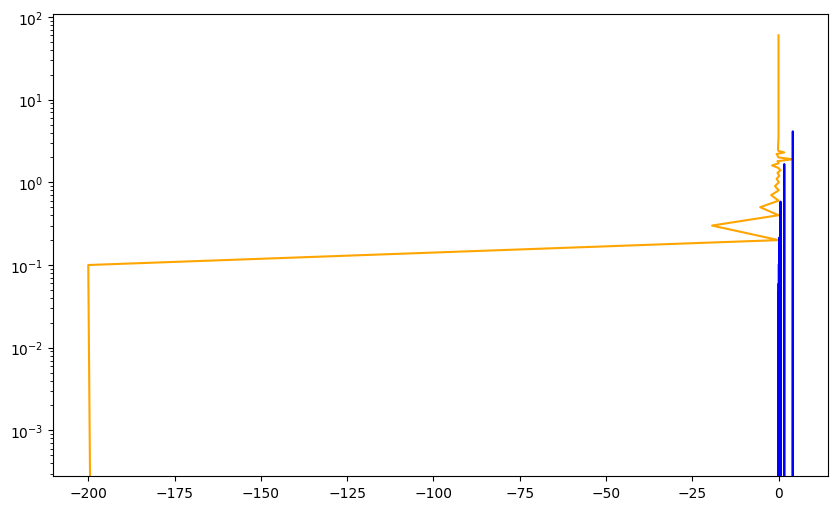

In [46]:
def Green_Ampt_data(h0, hf, theta_0, theta_i, Ks):

    delta_h = h0 - hf
    delta_theta = theta_0 - theta_i

    # Ein Array für die Infiltration. Annahme: Gesammtinfiltation = 60 cm
    I_t = np.arange(0,60.1,0.1)

    # Ein Array in derselben Länge mit 0en gefüllt, jeweils für die Zeit (t) und die Infiltrationsrate i
    t = np.zeros_like(I_t, dtype=float)
    i_t = t

    
    for i in range(1, len(I_t)):
        arg = 1 + (I_t[i] / (delta_h * delta_theta))
        if arg > 0:  # Ensure the argument of logarithm is positive
            t[i] = (I_t[i] - delta_h * delta_theta * np.log(arg)) / Ks
            if t[i] - t[i - 1] != 0:  # To avoid division by zero
                i_t[i] = (I_t[i] - I_t[i - 1]) / (t[i] - t[i - 1])

    return i_t, I_t, t



def plot_Infiltration(h0, hf, theta_0, theta_i, Ks, i_string=''):

    if i_string == '':
        break
    else:
        i_data = i_string.split(',')
        for i in i_data:
            i = float(i)

    i_t, I_t, t = Green_Ampt_data(h0, hf, theta_0, theta_i, Ks)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(t, I_t, marker='+', color='orange', linestyle='-', label='I')
    ax.plot(t, i_t, color='blue', linestyle='-', label='i')
    plt.yscale('log')

interact(plot_Infiltration,
         )

def plot_InfiltrationRate(h0, hf, theta_0, theta_i, Ks):
    i_t, I_t, t = Green_Ampt_data(h0, hf, theta_0, theta_i, Ks)
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(t, I_t, marker='+', color='orange', linestyle='-', label='I')
    ax.plot(t, i_t, color='blue', linestyle='-', label='i')
    plt.yscale('log')




In [42]:
class GreenAmptModel:
    def __init__(self, h0, theta_0):
        self.h0 = h0
        self.theta_0 = theta_0
        self.reference_lines = []
        self.ref_line_params = []
        self.short_time_ref = []
        self.short_time_params = []
        self.infiltration_rate_ref = []


    def t_for_cum_inf(self, i_t, d_theta, d_h, Ks):
        return (i_t - d_theta * d_h * np.log(1+ (i_t/(d_theta*d_h))))/Ks

    def short_time_approximation(self, d_theta, d_h, K, t):
        """Short time approximation for cumulative infiltration
        Parameters
        ----------
        d_theta : float
            Change in volumetric water content
        d_h : float
            Change in pressure head
        K : float
            Hydraulic conductivity
        t : array_like
            Time
        Returns
        -------
        i_t : array
            Cumulative infiltration"""

        return np.sqrt((d_theta*d_h*K)/(2*t))

    def long_time_approximation(self, K, x):
        """Long time approximation for cumulative infiltration
        Parameters
        ----------
        K : float
            Hydraulic conductivity
        t : array_like
            Time
        Returns
        -------
        K : float
            Hydraulic conductivity"""

        it_long = np.array([K]*len(x))

        return it_long

    def d_h(self, h0, hf):
        return h0 - hf

    def d_theta(self, theta_0, theta_i):
        return theta_0 - theta_i
    
    def infiltration_rate(self, new_x, t, I_t):
        y2 = np.interp(new_x, t, I_t)
        diff = np.diff(y2)
        self.diff = diff
        return diff
    

    def plot_scenario_1(self, hf=-60, theta_i=0.2, Ks=4):
        delta_theta = self.d_theta(self.theta_0, theta_i)
        delta_h = self.d_h(self.h0, hf)

        I_t = np.arange(0, 260, 0.1)
        t = self.t_for_cum_inf(I_t, delta_theta, delta_h, Ks)
        # write the time to a file
        np.savetxt('time.txt', t, delimiter=',')
        self.new_x = np.arange(round(t[0], 1), round(t[-1], 1), 0.01)

        self.infiltration_rate(self.new_x, t, I_t)
        
        i_t_short = self.short_time_approximation(delta_theta, delta_h, Ks, self.new_x)
        i_t_long = self.long_time_approximation(Ks, self.new_x)

        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot all reference lines for the short time approximation
        for ref, params in zip(self.reference_lines, self.ref_line_params):
            ref_x, ref_y = ref
            ax.plot(ref_x, ref_y, linestyle='-.', alpha=0.6, label='hf:{} theta_i:{} Ks:{}'.format(params[0], params[1], params[2]))

        #plot reference line for infiltration rate
        for ref, params in zip(self.infiltration_rate_ref, self.ref_line_params):
            ref_x, ref_y = ref
            ax.plot(ref_x, ref_x, linestyle='-.', alpha=0.6, label='hf:{} theta_i:{} Ks:{}'.format(params[0], params[1], params[2]), linewidth=2.5)

        ax.plot(self.new_x[1:-5], self.diff[:-5]*100, color='black', label="theta_i=" + str(theta_i) + ", hf=" + str(hf), linewidth=2.5)
        ax.plot(self.new_x, i_t_short, 'orange', linestyle='-.', label='Short time approximation')
        ax.plot(self.new_x, i_t_long, 'red', linestyle='--', label='Long time approximation')

        ax.set_ylim(0.1, 140)
        ax.set_xlim(-5, max(self.new_x))
        plt.yscale('log')
        ax.set_xlabel('Time [h]', fontsize=12)
        ax.set_ylabel('infiltration rate [cm/h]', fontsize=12)

        # Move the legend outside of the plot
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.show()

    def on_button_click(self, button):
        # Current parameter values
        hf_val = self.h_slider.value[1]
        h0_val = self.h_slider.value[0]
        theta_i_val = self.theta_slider.value[1]
        theta_0_val = self.theta_slider.value[0]
        Ks_val = self.Ks_slider.value

        delta_theta = self.d_theta(theta_0_val, theta_i_val)
        delta_h = self.d_h(h0_val, hf_val)

        I_t = np.arange(0, 260, 0.1)
        t = self.t_for_cum_inf(I_t, delta_theta, delta_h, Ks_val)
        print(t)
        #self.new_x = np.arange(round(t[0], 1), round(t[-1], 1), 0.01)
        i_t_short = self.short_time_approximation(delta_theta, delta_h, Ks_val, self.new_x)

        # Store the current short time approximation data as a reference line
        self.reference_lines.append((self.new_x, i_t_short))
        self.ref_line_params.append((hf_val, theta_i_val, Ks_val))
        self.short_time_ref.append((self.new_x, i_t_short))
        self.short_time_params.append((hf_val, theta_i_val, Ks_val))

        diff = self.infiltration_rate(self.new_x, t, I_t)
        self.infiltration_rate_ref.append((self.new_x[1:-5], self.diff[:-5]*100))

        clear_output(wait=True)
        display(self.interactive_plot)
        display(button)


    def create_interactive_plot(self):
        # Create the button
        button = Button(description="Fixate Short time approximation")
        button.on_click(self.on_button_click)

        # Create sliders for the parameters
        self.h_slider = widgets.FloatRangeSlider(value=-60, min=-200, max=0, step=1, description='hf:')
        self.theta_slider = widgets.FloatRangeSlider(value=0.2, min=0, max=0.5, step=0.01, description='theta_i:')
        self.Ks_slider = widgets.FloatSlider(value=4, min=0, max=10, step=0.1, description='Ks:')

        # Display the interactive plot with the sliders and button
        self.interactive_plot = interactive(self.plot_scenario_1, hf=self.h_slider[1], h0=self.h_slider[0],theta_0=self.theta_slider[0], theta_i=self.theta_slider[1], Ks=self.Ks_slider)
        display(self.interactive_plot)        
        display(button)


In [45]:
GreenAmptModel(h0=0.0, theta_0=0.44).create_interactive_plot()
#theta und h als intrangslder
#buttn fü longtime + schwarz


TypeError: A 'range' must be able to be cast to a tuple. The input of type <class 'int'> could not be cast to a tuple

In [ ]:

def read_csv(data_path, col_name_inf, col_name_t):

    if data_path and col_name_inf and col_name_t != '':
        data = pd.read_csv(data_path, parse_dates=True, sep=';')
        infiltration_data = data[col_name_inf].values
        timesteps_data = data[col_name_t].values

        if len(infiltration_data) == len(timesteps_data):
            return infiltration_data, timesteps_data
        else:
            print('!Fehler!: Die Infiltrationsdaten haben nicht die selbe Länge, wie die Zeitdaten')

    else:
        print('!Fehler! :Es sind nicht alle Felder korekt ausgefüllt, es werden keine Daten eingelesen')


def plot_Infiltration(data_path, col_name_inf, col_name_t):

    infiltration_data, timesteps_data = read_csv(data_path, col_name_inf, col_name_t)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(timesteps_data, infiltration_data, marker='x', color='orange', linestyle='', label='Messdaten Infiltrationsversuch')
    xticks = np.arange(0,30,10)
    ax.set_xticks(xticks)

    #ax.set_ylim(0.1, max(infiltration_data)+1)
    #ax.set_xlim(-5, max(timesteps_data))
    plt.yscale('log')
    ax.set_xlabel('Time [h]', fontsize=12)
    ax.set_ylabel('infiltration rate [cm/h]', fontsize=12)

    # Move the legend outside of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    


interact(plot_Infiltration,
         data_path = widgets.Text(placeholder='Hier Dateipfad einfügen', description='Dateipfad: ', disabled=False),
         col_name_t = widgets.Text(placeholder='Hier Spaltenname für Zeitdaten einfügen', description='Zeitdaten: ', disabled=False),
         col_name_inf = widgets.Text(placeholder='Hier Spaltenname für Infiltraton einfügen', description='Infiltrationsdaten: ', disabled=False)
        )


#cum + sch
#mm/min
#eingabe für f1. plt und F 2. plt und t


interactive(children=(Text(value='', description='Dateipfad: ', placeholder='Hier Dateipfad einfügen'), Text(v…

<function __main__.plot_Infiltration(data_path, col_name_inf, col_name_t)>